## Notebook exploring the finetuning of XLnet


In [10]:
import os
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import XLNetTokenizer, XLNetForSequenceClassification
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

### Data loading

A custom dataloader has to built, where we will use the existing XLNetTokenizer to encode our input instead of relying on a vocab class


In [11]:
class XLimdbDataset(Dataset):
    def __init__(self,
                 data_dir:str,
                 max_token_len:int,
                 tokenizer:XLNetTokenizer,
                 is_train:bool=True):
        """
        IMDB Dataset Class
        The dataset will be created by reading all documents inside the file and encoded by XLnet encoder
        
        Args:
            data_dir (str): path to imdb parent folder
            max_token_len (int): maximum number of tokens per review
            tokenizer (XLNetTokenizer): XLNet tokenizer
            is_train (bool, optional): is the dataset train? Will take from train folder if True. Defaults to True.
        
        Returns:
            input_ids, attention_mask, labels
        """

        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.data_list, self.label_list = self._read_imdb(data_dir, is_train)


    def _read_imdb(self, data_dir, is_train):
        data = []
        labels = []
        data_folder = 'train' if is_train else 'test'
        
        for label, label_folder in enumerate(['neg', 'pos']):
            # Retrieve full path
            full_path = os.path.join(data_dir, data_folder, label_folder)
            for text_file in os.listdir(full_path):
                # Read text
                with open(os.path.join(full_path, text_file), 'r', encoding='utf-8') as f:
                    # Add text and label
                    data.append(f.read())
                    labels.append(label)
        return data, labels


    def __len__(self):
        return len(self.data_list)


    def __getitem__(self, idx):
        doc_data = self.data_list[idx]
        # Encode data and add padding automatically
        encoding = self.tokenizer(
            doc_data,
            max_length=self.max_token_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        # Input_ids, Attention_mask, Label
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), encoding['token_type_ids'].squeeze(0), torch.tensor(self.label_list[idx], dtype=torch.long)

In [13]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

train_dataset = XLimdbDataset(data_dir="../data/aclImdb",
                            max_token_len=256,
                            tokenizer=tokenizer)

test_dataset = XLimdbDataset(data_dir="../data/aclImdb",
                            max_token_len=256,
                            tokenizer=tokenizer,
                            is_train=False)

In [4]:
train_iter = DataLoader(train_dataset,
                        batch_size=32, 
                        shuffle=True,
                        )

test_iter = DataLoader(test_dataset,
                        batch_size=32
                        )

### Model Architecture

We will use a pre-trained XLNetModel from hugging face, but modify the final linear layer and also unfreeze the last layer

In [14]:
class XLNetFineTunedModel(torch.nn.Module):
    def __init__(self,
                 device:str, 
                 num_class:int, 
                 unfreeze_all:bool=False
                 ):
        """
        XLNet model class, loads pretrained xlnet from hugging face
        Option to unfreeze all layers, but if set to false it will only unfreeze the linear layers (classification layers)

        Args:
            device (str): cpu or cuda
            num_class (int): Total number of labels
            unfreeze_all (bool, optional): Unfreeze all layers in XLNet. Defaults to False.
        """
        super().__init__() 
        self.model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=num_class).to(device)

        if not unfreeze_all:
            for name, param in self.model.named_parameters():
                # Retrieve linear classification layers
                if name in ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']:  
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        else:
            # Unfreeze all
            for param in self.model.parameters():
                param.requires_grad = True

    
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.model(input_ids=input_ids, 
                             attention_mask=attention_mask, 
                             token_type_ids=token_type_ids,
                             labels=labels)
        return outputs

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlNet_model = XLNetFineTunedModel(device, num_class=2)
print(xlNet_model)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetFineTunedModel(
  (model): XLNetForSequenceClassification(
    (transformer): XLNetModel(
      (word_embedding): Embedding(32000, 768)
      (layer): ModuleList(
        (0-11): 12 x XLNetLayer(
          (rel_attn): XLNetRelativeAttention(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (ff): XLNetFeedForward(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (layer_1): Linear(in_features=768, out_features=3072, bias=True)
            (layer_2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (activation_function): GELUActivation()
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sequence_summary): SequenceSummary(
      (summary): Linear(in_features=768, out_features=768, b

### Training and evaluation

In [15]:
def eval_model(model:XLNetFineTunedModel,
               test_iter:DataLoader,
               device:str,
               tokenizer: XLNetTokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased'),
               calc_confusion_matrix:bool=False,
               download_results:bool=False,
               result_path:str=None,
               ):
    
    """
    Function to evaluate model, returning the Accuracy, Precision, Recall and F1 score

    Args:
        model (XLNetFineTunedModel): Instance of model
        test_iter (DataLoader): test dataloader
        device (str): cpu or cuda
        tokenizer (XLNetTokenizer, Optional): tokenizer to decode input_ids back to sentence for download results. Defaults to XLNetTokenizer
        calc_confusion_matrix (bool, Optional): Boolean if Precision, Recall and F1 score should also be calculated. Defaults to False.
        download_results (bool, Optional): Boolean to save predictions into a csv file. Defaults to False.
        result_path (str, Optional): CSV filepath for results
    
    Returns:
        accuracy, recall (None if calc_confusion_matrix == False), precision (None if calc_confusion_matrix == False), f1 (None if calc_confusion_matrix == False)
    """

    if download_results and result_path == None and '.csv' not in result_path:
        raise Exception("Invalid result filepath")

    prediction_list = []
    actual_list = []

    # For donwload results
    sentence_list = []
    predicted_labels = []
    actual_labels = []

    recall, precision, f1 = None, None, None

    # Setup model eval to prevent training
    model.eval()
    for idx, (input_ids, attention_masks, token_type_ids, label) in tqdm(enumerate(test_iter), total=len(test_iter)):
        # Append actual scores
        actual_list.append(label.numpy())
        input_ids, attention_masks, token_type_ids, label = input_ids.to(device), attention_masks.to(device), token_type_ids.to(device), label.to(device)
        outputs = model(input_ids, attention_masks, token_type_ids, label)
        
        # Append predicted scores
        logits = outputs.logits #Retrieve softmax logits
        predicted = torch.argmax(logits, dim=-1)
        prediction_list.append(predicted.cpu().numpy())

        # Append results
        if download_results:
            # Iterate through the input sentences in batch
            for ids in input_ids:  
                sentence_list.append(tokenizer.decode(ids.cpu().numpy().tolist(), skip_special_tokens=True))
            # Labels            
            predicted_labels.extend(["negative" if pred == 0 else "positive" for pred in predicted.cpu().numpy()])
            actual_labels.extend(["negative" if pred == 0 else "positive" for pred in label.cpu().numpy()])


    # Flatten the lists into arrays
    actual_list = np.concatenate(actual_list)
    prediction_list = np.concatenate(prediction_list)

    # Calculate accuracy
    accuracy = accuracy_score(actual_list, prediction_list)

    # Calculate other metrics
    if calc_confusion_matrix:
        recall = recall_score(actual_list, prediction_list)
        precision = precision_score(actual_list, prediction_list)
        f1 = f1_score(actual_list, prediction_list)
    
    # Download results
    if download_results:
        data = pd.DataFrame({
            'Sentence': sentence_list,
            'Actual': actual_labels,
            "Predicted": predicted_labels
        })

        data.to_csv(result_path, index=False)

    return accuracy, recall, precision, f1

In [8]:
def train_model(model:XLNetFineTunedModel, 
                train_iter:DataLoader, 
                test_iter:DataLoader, 
                num_epochs:int, 
                optimiser, 
                lr_scheduler, 
                device:str,
                show_training_graph:bool,
                best_model_path:str, 
                final_model_path:str):
    
    """
    Function to train and evaluate model
    The model will train on the train_iter, be evaluated on test_iter
    Best model with highest accuracy on test_iter will be saved in best_model_path
    Final model after last epoch will be saved in final_model_path

    Args:
        model (XLNetFineTunedModel): model to be trained
        train_iter (DataLoader): train dataset
        test_iter (DataLoader): test dataset
        num_epochs (int): Number of epochs to train
        optimiser: optimiser
        lr_scheduler: learning rate scheduler, else None
        device (str): cpu or cuda
        show_training_graph (bool): boolean to show the training loss, training acc and test acc graph across epochs
        best_model_path (str): path to best model
        final_model_path (str): path to model aft final epoch training
    """
    train_loss_container = []
    train_acc_container = []
    test_acc_container = []

    best_test_acc = 0

    for epoch in range(num_epochs):
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0

        # Setup training 
        model.train()
        model.to(device)

        for idx, (input_ids, attention_masks, token_type_ids, label) in tqdm(enumerate(train_iter), total=len(train_iter)):
            input_ids, attention_masks, token_type_ids, label = input_ids.to(device), attention_masks.to(device), token_type_ids.to(device), label.to(device)
            # Get predictions and loss
            outputs = model(input_ids, attention_masks, token_type_ids, label)
            # Loss is automatically calculated with BCE from XLNt
            loss = outputs.loss
            total_train_loss += loss.item()

            # Train
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            if lr_scheduler:
                lr_scheduler.step()

            # Count accuracy
            logits = outputs.logits #Retrieve softmax logits
            predicted = torch.argmax(logits, dim=-1)            
            total_train_correct += (predicted == label).sum().item()
            total_train_samples += label.shape[0]

        # Evaluation for test
        test_acc, _, _, _ = eval_model(model, test_iter, device)

        train_loss_container.append(total_train_loss/len(train_iter)) #total num of batches
        train_acc_container.append(total_train_correct/total_train_samples)
        test_acc_container.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model, best_model_path)
            print(f"Best Model Saved at epoch {epoch+1}")

        print(f"Epoch {epoch+1} completed, train_loss: {total_train_loss/len(train_iter)}, train_acc: {total_train_correct/total_train_samples}, test_acc: {test_acc}")

    # Save Final model 
    torch.save(model, final_model_path)

    if show_training_graph:
        # Graph with matplotlib
        # Plot each list
        plt.plot(train_loss_container, label='Train Loss', color='blue')
        plt.plot(train_acc_container, label='Train Acc', color='green')
        plt.plot(test_acc_container, label='Test Acc', color='red')

        # Add labels and legend
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()


100%|██████████| 782/782 [02:29<00:00,  5.23it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.6414416648847673, train_acc: 0.64476, test_acc: 0.76368


100%|██████████| 782/782 [02:30<00:00,  5.19it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.5575734518296883, train_acc: 0.75676, test_acc: 0.80504


100%|██████████| 782/782 [02:30<00:00,  5.19it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.5080137301970016, train_acc: 0.78728, test_acc: 0.82448


100%|██████████| 782/782 [02:30<00:00,  5.18it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.47496611302923364, train_acc: 0.80752, test_acc: 0.83536


100%|██████████| 782/782 [02:33<00:00,  5.09it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.45170360982722946, train_acc: 0.81148, test_acc: 0.84324


100%|██████████| 782/782 [02:30<00:00,  5.19it/s]


Best Model Saved at epoch 6
Epoch 6 completed, train_loss: 0.43862638883578503, train_acc: 0.81664, test_acc: 0.84592


100%|██████████| 782/782 [02:31<00:00,  5.15it/s]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.4204720134091804, train_acc: 0.8246, test_acc: 0.84964


100%|██████████| 782/782 [02:28<00:00,  5.26it/s]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.4118579866750466, train_acc: 0.82932, test_acc: 0.85404


100%|██████████| 782/782 [02:28<00:00,  5.27it/s]


Best Model Saved at epoch 9
Epoch 9 completed, train_loss: 0.40436082920226296, train_acc: 0.83044, test_acc: 0.85624


100%|██████████| 782/782 [02:28<00:00,  5.26it/s]


Best Model Saved at epoch 10
Epoch 10 completed, train_loss: 0.39430567909918174, train_acc: 0.83744, test_acc: 0.85752


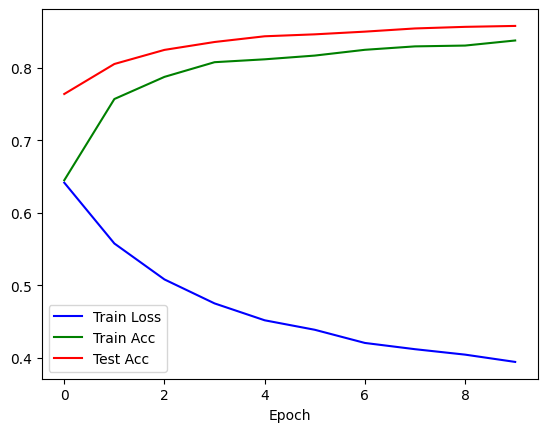

In [12]:
# 256, 32
lr, num_epochs = 2e-5, 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(xlNet_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=10)

train_model(xlNet_model, train_iter, test_iter, num_epochs, optimizer, scheduler, device, True, '../models/best_XLNET_32_256.pt', '../models/final_XLNET_32_256.pt')

100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.6747095784567811, train_acc: 0.58072, test_acc: 0.73552


100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.6053153924320055, train_acc: 0.71396, test_acc: 0.80328


100%|██████████| 391/391 [02:51<00:00,  2.29it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.5571987822537532, train_acc: 0.76008, test_acc: 0.80908


100%|██████████| 391/391 [02:51<00:00,  2.28it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.5206873941299556, train_acc: 0.78592, test_acc: 0.82376


100%|██████████| 391/391 [02:51<00:00,  2.28it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.49387999218138284, train_acc: 0.79848, test_acc: 0.83332


100%|██████████| 391/391 [02:51<00:00,  2.28it/s]


Best Model Saved at epoch 6
Epoch 6 completed, train_loss: 0.47476719148323665, train_acc: 0.8026, test_acc: 0.83856


100%|██████████| 391/391 [02:51<00:00,  2.28it/s]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.4573307273637913, train_acc: 0.81068, test_acc: 0.8426


100%|██████████| 391/391 [02:51<00:00,  2.28it/s]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.44392422276079807, train_acc: 0.818, test_acc: 0.84568


100%|██████████| 391/391 [02:53<00:00,  2.26it/s]


Best Model Saved at epoch 9
Epoch 9 completed, train_loss: 0.4321190178241876, train_acc: 0.81992, test_acc: 0.84836


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Best Model Saved at epoch 10
Epoch 10 completed, train_loss: 0.4210635102770822, train_acc: 0.82656, test_acc: 0.85064


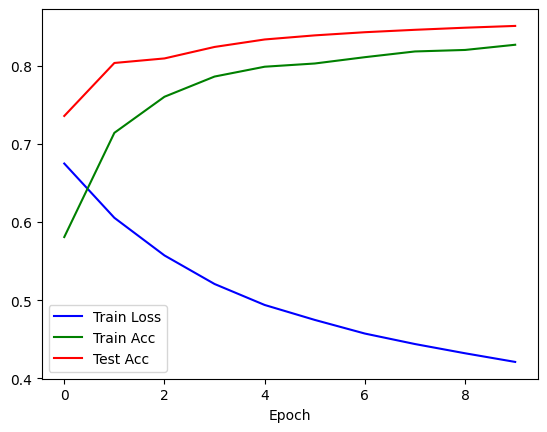

In [17]:
# 256, 64
lr, num_epochs = 2e-5, 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(xlNet_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=10)

train_model(xlNet_model, train_iter, test_iter, num_epochs, optimizer, scheduler, device, True, '../models/best_XLNET_64_256.pt', '../models/final_XLNET_64_256.pt')

100%|██████████| 782/782 [02:29<00:00,  5.23it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.5331379978172005, train_acc: 0.76916, test_acc: 0.8332


100%|██████████| 782/782 [02:29<00:00,  5.23it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.4525917409097447, train_acc: 0.81232, test_acc: 0.85056


100%|██████████| 782/782 [02:30<00:00,  5.20it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.4129301593889056, train_acc: 0.82676, test_acc: 0.85492


100%|██████████| 782/782 [02:28<00:00,  5.25it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.3953932086982386, train_acc: 0.833, test_acc: 0.8606


100%|██████████| 782/782 [02:28<00:00,  5.25it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.3868749114253637, train_acc: 0.83576, test_acc: 0.86504


100%|██████████| 782/782 [02:30<00:00,  5.20it/s]


Best Model Saved at epoch 6
Epoch 6 completed, train_loss: 0.37525428711529585, train_acc: 0.83976, test_acc: 0.868


100%|██████████| 782/782 [02:30<00:00,  5.19it/s]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.3672154870865595, train_acc: 0.84208, test_acc: 0.86856


100%|██████████| 782/782 [02:30<00:00,  5.19it/s]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.362581558744697, train_acc: 0.84544, test_acc: 0.87036


100%|██████████| 782/782 [02:31<00:00,  5.17it/s]


Best Model Saved at epoch 9
Epoch 9 completed, train_loss: 0.3619973626931, train_acc: 0.84612, test_acc: 0.87228


100%|██████████| 782/782 [02:34<00:00,  5.06it/s]


Best Model Saved at epoch 10
Epoch 10 completed, train_loss: 0.3586242839960796, train_acc: 0.84628, test_acc: 0.87308


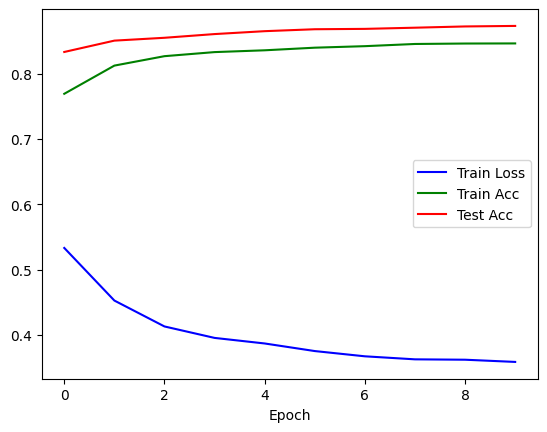

In [26]:
# 256, 32
lr, num_epochs = 5e-5, 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(xlNet_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=10)

train_model(xlNet_model, train_iter, test_iter, num_epochs, optimizer, scheduler, device, True, '../models/best_1XLNET_32_256.pt', '../models/final_1XLNET_32_256.pt')

100%|██████████| 782/782 [02:28<00:00,  5.28it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.6784463482134787, train_acc: 0.57016, test_acc: 0.68956


100%|██████████| 782/782 [02:28<00:00,  5.25it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.6248168536769155, train_acc: 0.68344, test_acc: 0.75676


100%|██████████| 782/782 [02:27<00:00,  5.31it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.5834284477755237, train_acc: 0.73992, test_acc: 0.79316


100%|██████████| 782/782 [02:27<00:00,  5.31it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.5520624951709567, train_acc: 0.76324, test_acc: 0.81216


100%|██████████| 782/782 [02:27<00:00,  5.31it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.52653157409957, train_acc: 0.78092, test_acc: 0.81864


100%|██████████| 782/782 [02:27<00:00,  5.30it/s]


Best Model Saved at epoch 6
Epoch 6 completed, train_loss: 0.5057546563465577, train_acc: 0.78876, test_acc: 0.82588


100%|██████████| 782/782 [02:29<00:00,  5.23it/s]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.4871646066760773, train_acc: 0.80048, test_acc: 0.83216


100%|██████████| 782/782 [02:28<00:00,  5.28it/s]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.4727584040149703, train_acc: 0.80396, test_acc: 0.83592


100%|██████████| 782/782 [02:28<00:00,  5.28it/s]


Best Model Saved at epoch 9
Epoch 9 completed, train_loss: 0.46170871676234027, train_acc: 0.809, test_acc: 0.84272


100%|██████████| 782/782 [02:29<00:00,  5.22it/s]


Best Model Saved at epoch 10
Epoch 10 completed, train_loss: 0.4493865368844908, train_acc: 0.81412, test_acc: 0.84432


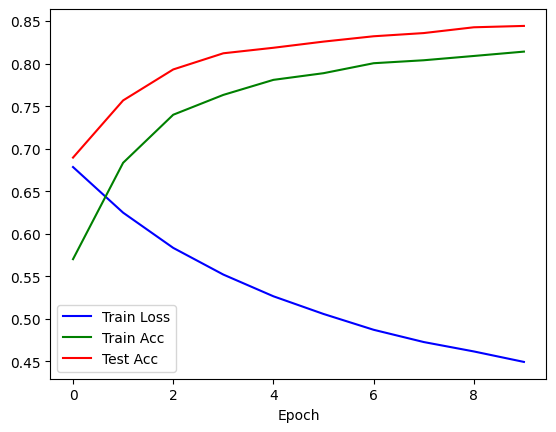

In [10]:
# 256, 32
lr, num_epochs = 1e-5, 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(xlNet_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=10)

train_model(xlNet_model, train_iter, test_iter, num_epochs, optimizer, scheduler, device, True, '../models/best_2XLNET_32_256.pt', '../models/final_2XLNET_32_256.pt')

100%|██████████| 782/782 [02:28<00:00,  5.28it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.41687796617407935, train_acc: 0.81676, test_acc: 0.86844


100%|██████████| 782/782 [02:28<00:00,  5.28it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.36576006332855393, train_acc: 0.84324, test_acc: 0.87088


100%|██████████| 782/782 [02:27<00:00,  5.30it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.35568206258060986, train_acc: 0.8472, test_acc: 0.8764


100%|██████████| 782/782 [02:27<00:00,  5.29it/s]


Epoch 4 completed, train_loss: 0.35706599284430296, train_acc: 0.84548, test_acc: 0.87608


100%|██████████| 782/782 [02:30<00:00,  5.19it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.3555408265927564, train_acc: 0.84488, test_acc: 0.87952


100%|██████████| 782/782 [02:30<00:00,  5.20it/s]


Epoch 6 completed, train_loss: 0.3559438120716673, train_acc: 0.84572, test_acc: 0.8772


100%|██████████| 782/782 [02:27<00:00,  5.30it/s]


Epoch 7 completed, train_loss: 0.3522818717543426, train_acc: 0.84656, test_acc: 0.87872


100%|██████████| 782/782 [02:27<00:00,  5.29it/s]


Epoch 8 completed, train_loss: 0.34746913295572673, train_acc: 0.84924, test_acc: 0.87708


100%|██████████| 782/782 [02:27<00:00,  5.31it/s]


Epoch 9 completed, train_loss: 0.3455941690146313, train_acc: 0.8502, test_acc: 0.87716


100%|██████████| 782/782 [02:27<00:00,  5.31it/s]


Epoch 10 completed, train_loss: 0.3490688393602286, train_acc: 0.84656, test_acc: 0.87928


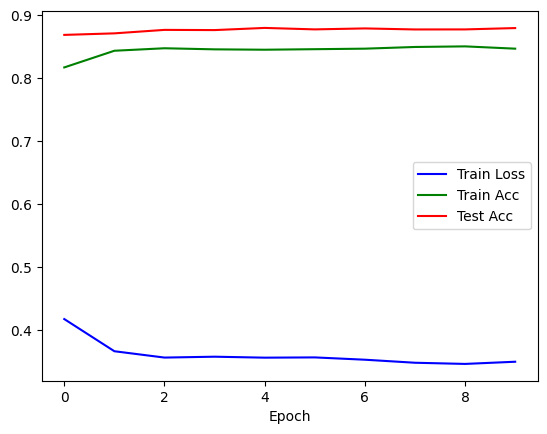

In [14]:
# 256, 64
lr, num_epochs = 5e-5, 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(xlNet_model.parameters(), lr=lr)

train_model(xlNet_model, train_iter, test_iter, num_epochs, optimizer, None, device, True, '../models/best_3XLNET_32_256.pt', '../models/final_3XLNET_32_256.pt')

100%|██████████| 782/782 [02:27<00:00,  5.31it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.41064261194423335, train_acc: 0.81936, test_acc: 0.87064


100%|██████████| 782/782 [02:26<00:00,  5.35it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.3649201718304316, train_acc: 0.84232, test_acc: 0.87608


100%|██████████| 782/782 [02:26<00:00,  5.35it/s]


Epoch 3 completed, train_loss: 0.35632129743352264, train_acc: 0.8486, test_acc: 0.8736


100%|██████████| 782/782 [02:26<00:00,  5.35it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.35258003516727704, train_acc: 0.8472, test_acc: 0.8762


100%|██████████| 782/782 [02:26<00:00,  5.35it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.35338354270781397, train_acc: 0.84808, test_acc: 0.8772


100%|██████████| 782/782 [02:26<00:00,  5.34it/s]


Epoch 6 completed, train_loss: 0.34989857319218426, train_acc: 0.84804, test_acc: 0.87664


100%|██████████| 782/782 [02:26<00:00,  5.35it/s]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.3488419707435781, train_acc: 0.8478, test_acc: 0.87944


100%|██████████| 782/782 [02:26<00:00,  5.35it/s]


Epoch 8 completed, train_loss: 0.34425239013436504, train_acc: 0.85236, test_acc: 0.8774


100%|██████████| 782/782 [02:26<00:00,  5.32it/s]


Epoch 9 completed, train_loss: 0.3526613820258461, train_acc: 0.84492, test_acc: 0.87852


100%|██████████| 782/782 [02:26<00:00,  5.35it/s]


Epoch 10 completed, train_loss: 0.34536714272578356, train_acc: 0.85032, test_acc: 0.87836


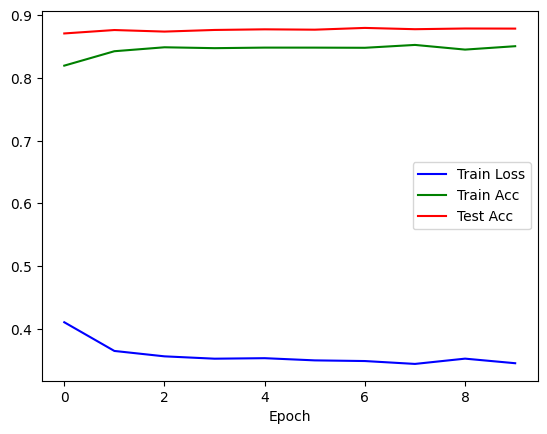

In [17]:
# 256, 32
lr, num_epochs = 5e-4, 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(xlNet_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=10)

train_model(xlNet_model, train_iter, test_iter, num_epochs, optimizer, scheduler, device, True, '../models/best_4XLNET_32_256.pt', '../models/final_4XLNET_32_256.pt')

100%|██████████| 782/782 [02:25<00:00,  5.37it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.39933716309497425, train_acc: 0.8198, test_acc: 0.86112


100%|██████████| 782/782 [02:24<00:00,  5.40it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.3628873352694999, train_acc: 0.8388, test_acc: 0.8754


100%|██████████| 782/782 [02:24<00:00,  5.40it/s]


Epoch 3 completed, train_loss: 0.3559027689192301, train_acc: 0.8438, test_acc: 0.86936


100%|██████████| 782/782 [02:26<00:00,  5.35it/s]


Epoch 4 completed, train_loss: 0.35512859402867536, train_acc: 0.84416, test_acc: 0.87228


100%|██████████| 782/782 [02:26<00:00,  5.32it/s]


Epoch 5 completed, train_loss: 0.34960371500733867, train_acc: 0.8466, test_acc: 0.85168


100%|██████████| 782/782 [02:26<00:00,  5.35it/s]


Epoch 6 completed, train_loss: 0.34651942174795947, train_acc: 0.84836, test_acc: 0.87452


100%|██████████| 782/782 [02:25<00:00,  5.37it/s]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.34084476488630483, train_acc: 0.85172, test_acc: 0.8806


100%|██████████| 782/782 [02:25<00:00,  5.36it/s]


Epoch 8 completed, train_loss: 0.34678858599585033, train_acc: 0.84852, test_acc: 0.87248


100%|██████████| 782/782 [02:25<00:00,  5.37it/s]


Epoch 9 completed, train_loss: 0.33644876922564126, train_acc: 0.8528, test_acc: 0.8744


100%|██████████| 782/782 [02:26<00:00,  5.33it/s]


Epoch 10 completed, train_loss: 0.3385183572045068, train_acc: 0.85168, test_acc: 0.88032


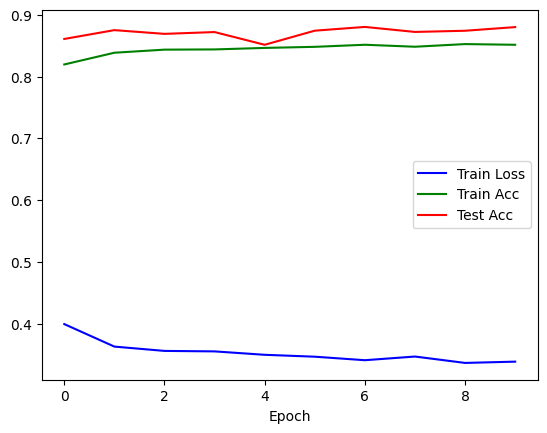

In [21]:
# 256, 32
lr, num_epochs = 5e-4, 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(xlNet_model.parameters(), lr=lr)

train_model(xlNet_model, train_iter, test_iter, num_epochs, optimizer, None, device, True, '../models/best_5XLNET_32_256.pt', '../models/final_5XLNET_32_256.pt')

  0%|          | 0/782 [00:00<?, ?it/s]

100%|██████████| 782/782 [07:59<00:00,  1.63it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.3495573180887248, train_acc: 0.84848, test_acc: 0.89288


100%|██████████| 782/782 [07:59<00:00,  1.63it/s]


Epoch 2 completed, train_loss: 0.3211755616604672, train_acc: 0.86212, test_acc: 0.87256


100%|██████████| 782/782 [08:01<00:00,  1.62it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.31262634651702076, train_acc: 0.86652, test_acc: 0.9006


100%|██████████| 782/782 [07:52<00:00,  1.65it/s]


Epoch 4 completed, train_loss: 0.3103126900656449, train_acc: 0.86912, test_acc: 0.89548


100%|██████████| 782/782 [07:54<00:00,  1.65it/s]


Epoch 5 completed, train_loss: 0.30787096504131545, train_acc: 0.87012, test_acc: 0.89928


100%|██████████| 782/782 [07:57<00:00,  1.64it/s]


Epoch 6 completed, train_loss: 0.3014716362423452, train_acc: 0.8722, test_acc: 0.89708


100%|██████████| 782/782 [08:10<00:00,  1.60it/s]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.30074871270476705, train_acc: 0.87096, test_acc: 0.90424


100%|██████████| 782/782 [08:09<00:00,  1.60it/s]


Epoch 8 completed, train_loss: 0.2965660967275767, train_acc: 0.87484, test_acc: 0.90404


100%|██████████| 782/782 [08:09<00:00,  1.60it/s]


Best Model Saved at epoch 9
Epoch 9 completed, train_loss: 0.2949825379321033, train_acc: 0.87596, test_acc: 0.9052


100%|██████████| 782/782 [08:09<00:00,  1.60it/s]


Epoch 10 completed, train_loss: 0.2944976036601207, train_acc: 0.87652, test_acc: 0.89004


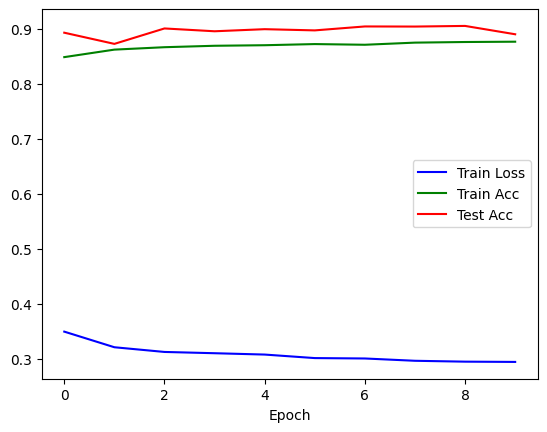

In [10]:
# 512, 32
lr, num_epochs = 5e-4, 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(xlNet_model.parameters(), lr=lr)

train_model(xlNet_model, train_iter, test_iter, num_epochs, optimizer, None, device, True, '../models/best_XLNET_32_512.pt', '../models/final_XLNET_32_512.pt')

100%|██████████| 782/782 [08:08<00:00,  1.60it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.3772828450516971, train_acc: 0.842, test_acc: 0.89344


100%|██████████| 782/782 [08:08<00:00,  1.60it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.3215113806507319, train_acc: 0.86492, test_acc: 0.89896


100%|██████████| 782/782 [08:08<00:00,  1.60it/s]


Epoch 3 completed, train_loss: 0.31067771126356575, train_acc: 0.86924, test_acc: 0.89856


100%|██████████| 782/782 [08:08<00:00,  1.60it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.30877819279080154, train_acc: 0.87156, test_acc: 0.90144


100%|██████████| 782/782 [08:08<00:00,  1.60it/s]


Epoch 5 completed, train_loss: 0.3064249610228231, train_acc: 0.87232, test_acc: 0.899


100%|██████████| 782/782 [08:08<00:00,  1.60it/s]


Epoch 6 completed, train_loss: 0.3058688650026803, train_acc: 0.87288, test_acc: 0.90092


100%|██████████| 782/782 [08:08<00:00,  1.60it/s]


Epoch 7 completed, train_loss: 0.3015039586664542, train_acc: 0.87348, test_acc: 0.89968


100%|██████████| 782/782 [08:08<00:00,  1.60it/s]


Epoch 8 completed, train_loss: 0.30504321611826984, train_acc: 0.8722, test_acc: 0.89876


100%|██████████| 782/782 [08:08<00:00,  1.60it/s]


Best Model Saved at epoch 9
Epoch 9 completed, train_loss: 0.3035566023910594, train_acc: 0.87312, test_acc: 0.90164


100%|██████████| 782/782 [08:08<00:00,  1.60it/s]


Epoch 10 completed, train_loss: 0.3024187266274029, train_acc: 0.87544, test_acc: 0.9002


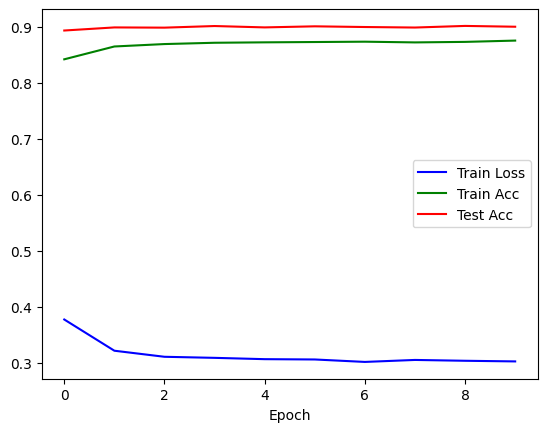

In [13]:
# 512, 32
lr, num_epochs = 5e-5, 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(xlNet_model.parameters(), lr=lr)

train_model(xlNet_model, train_iter, test_iter, num_epochs, optimizer, None, device, True, '../models/best_1XLNET_32_512.pt', '../models/final_1XLNET_32_512.pt')

100%|██████████| 782/782 [26:55<00:00,  2.07s/it]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.3364774449144864, train_acc: 0.8554, test_acc: 0.90524


100%|██████████| 782/782 [26:56<00:00,  2.07s/it]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.30531936588570896, train_acc: 0.87084, test_acc: 0.90544


100%|██████████| 782/782 [26:54<00:00,  2.06s/it]


Epoch 3 completed, train_loss: 0.29841460596265085, train_acc: 0.87768, test_acc: 0.9032


100%|██████████| 782/782 [26:54<00:00,  2.06s/it]


Epoch 4 completed, train_loss: 0.2909577278244069, train_acc: 0.87804, test_acc: 0.90224


100%|██████████| 782/782 [26:55<00:00,  2.07s/it]


Epoch 5 completed, train_loss: 0.2900004644718621, train_acc: 0.87888, test_acc: 0.90208


100%|██████████| 782/782 [26:57<00:00,  2.07s/it]


Epoch 6 completed, train_loss: 0.28658095703405495, train_acc: 0.88028, test_acc: 0.89724


100%|██████████| 782/782 [26:57<00:00,  2.07s/it]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.29021760399269936, train_acc: 0.87832, test_acc: 0.91092


100%|██████████| 782/782 [26:53<00:00,  2.06s/it]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.2799195594313886, train_acc: 0.88244, test_acc: 0.91276


100%|██████████| 782/782 [26:53<00:00,  2.06s/it]


Epoch 9 completed, train_loss: 0.2846478196885199, train_acc: 0.87936, test_acc: 0.90552


100%|██████████| 782/782 [26:55<00:00,  2.07s/it]


Epoch 10 completed, train_loss: 0.27735083851286824, train_acc: 0.88504, test_acc: 0.9024


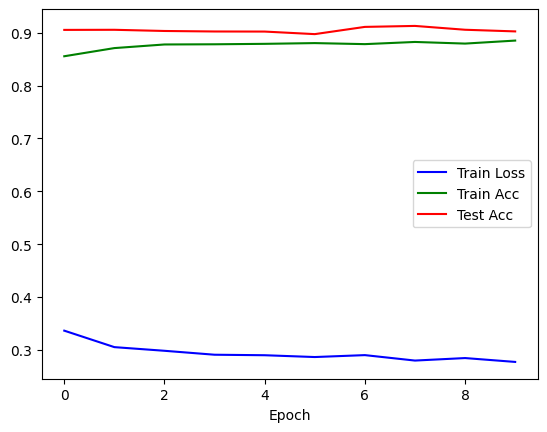

In [ ]:
# 1024, 32
lr, num_epochs = 5e-4, 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(xlNet_model.parameters(), lr=lr)

train_model(xlNet_model, train_iter, test_iter, num_epochs, optimizer, None, device, True, '../models/best_XLNET_32_1024.pt', '../models/final_XLNET_32_1024.pt')

### Evaluation

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('../models/best_XLNET_32_256.pt')
eval_model(model=model, 
           test_iter=test_iter, 
           device=device, 
           calc_confusion_matrix=True,
           download_results=True,
           result_path='../src/outputs/XLNet.csv')

100%|██████████| 782/782 [04:07<00:00,  3.15it/s]


(0.85752, 0.87392, 0.8461657629744385, 0.859818968909878)

### Evaluation with the new test data 

Since the test data is a csv, we will have to modify the _read_data function in the dataset

In [16]:
class TestXLimdbDataset(Dataset):
    def __init__(self,
                 csv_path:str,
                 max_token_len:int,
                 tokenizer:XLNetTokenizer):
        """
        Test Dataset Class
        The dataset will be created by reading all documents inside the file and encoded by XLnet encoder
        
        Args:
            csv_path (str): path to csv file
            max_token_len (int): maximum number of tokens per review
            tokenizer (XLNetTokenizer): XLNet tokenizer
        
        Returns:
            input_ids, attention_mask, labels
        """

        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.data_list, self.label_list = self._read_data(csv_path)


    def _read_data(self, csv_path):
        dataset = pd.read_csv(csv_path)
        data = dataset['text'].tolist()
        labels = dataset['label'].tolist()
        return data, labels


    def __len__(self):
        return len(self.data_list)


    def __getitem__(self, idx):
        doc_data = self.data_list[idx]
        # Encode data and add padding automatically
        encoding = self.tokenizer(
            doc_data,
            max_length=self.max_token_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        # Input_ids, Attention_mask, Label
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), encoding['token_type_ids'].squeeze(0), torch.tensor(self.label_list[idx], dtype=torch.long)

In [17]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

test_dataset = TestXLimdbDataset(csv_path="../data/test_data_movie.csv",
                            max_token_len=1024,
                            tokenizer=tokenizer)

In [18]:
test_iter = DataLoader(test_dataset,
                        batch_size=32
                        )

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('../models/best_XLNET_32_256.pt')
eval_model(model=model, 
           test_iter=test_iter, 
           device=device, 
           calc_confusion_matrix=True)

100%|██████████| 1250/1250 [04:00<00:00,  5.19it/s]


(0.858025, 0.8751814223512336, 0.8459268575851393, 0.860305512508302)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('../models/best_XLNET_64_256.pt')
eval_model(model=model, 
           test_iter=test_iter, 
           device=device, 
           calc_confusion_matrix=True)

100%|██████████| 625/625 [04:31<00:00,  2.30it/s]


(0.8515, 0.8619188228817376, 0.8440915551634564, 0.8529120443740095)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('../models/best_1XLNET_32_256.pt')
eval_model(model=model, 
           test_iter=test_iter, 
           device=device, 
           calc_confusion_matrix=True)

100%|██████████| 1250/1250 [04:03<00:00,  5.14it/s]


(0.8741, 0.8872428807366999, 0.8643167081078446, 0.8756297540254865)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('../models/best_2XLNET_32_256.pt')
eval_model(model=model, 
           test_iter=test_iter, 
           device=device, 
           calc_confusion_matrix=True)

100%|██████████| 1250/1250 [04:03<00:00,  5.13it/s]


(0.844625, 0.8519593613933236, 0.8393984220907298, 0.8456322495715457)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('../models/best_3XLNET_32_256.pt')
eval_model(model=model, 
           test_iter=test_iter, 
           device=device, 
           calc_confusion_matrix=True)

100%|██████████| 1250/1250 [04:02<00:00,  5.16it/s]


(0.88135, 0.8808367949552074, 0.8815426997245179, 0.8811896059680568)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('../models/best_4XLNET_32_256.pt')
eval_model(model=model, 
           test_iter=test_iter, 
           device=device, 
           calc_confusion_matrix=True)

100%|██████████| 1250/1250 [04:01<00:00,  5.19it/s]


(0.8812, 0.8881937840948901, 0.875746360720454, 0.8819261541519654)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('../models/best_5XLNET_32_256.pt')
eval_model(model=model, 
           test_iter=test_iter, 
           device=device, 
           calc_confusion_matrix=True)

100%|██████████| 1250/1250 [03:59<00:00,  5.22it/s]


(0.88405, 0.8778339422451329, 0.8886862238435426, 0.8832267485774712)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('../models/best_XLNET_32_512.pt')
eval_model(model=model, 
           test_iter=test_iter, 
           device=device, 
           calc_confusion_matrix=True)

100%|██████████| 1250/1250 [13:08<00:00,  1.59it/s]


(0.909325, 0.9122166057754867, 0.90681592039801, 0.9095082458022504)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('../models/best_1XLNET_32_512.pt')
eval_model(model=model, 
           test_iter=test_iter, 
           device=device, 
           calc_confusion_matrix=True)

100%|██████████| 1250/1250 [13:04<00:00,  1.59it/s]


(0.9031, 0.9142185075822031, 0.8941700523765236, 0.904083147735709)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('../models/best_XLNET_32_1024.pt')
eval_model(model=model, 
           test_iter=test_iter, 
           device=device, 
           calc_confusion_matrix=True,
           download_results=True,
           result_path='../src/outputs/XLNet.csv')


00%|██████████| 1250/1250 [56:25<00:00,  2.71s/it]

(0.914, 0.9212752114508783, 0.9079161528976573, 0.9145468998410174)